# Week 13 Lab: Unsupervised Learning (Clustering and PCA)

<a href="https://colab.research.google.com/github/bradleyboehmke/uc-bana-4080/blob/main/labs/13_wk13_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This lab introduces you to two fundamental unsupervised learning techniques: **K-Means clustering** and **Principal Component Analysis (PCA)**. Unlike supervised learning where we have labeled data, unsupervised learning discovers hidden patterns and structures in data without predefined outcomes.

In Part A, you'll work through guided examples with customer segmentation data and housing data to understand how clustering groups similar observations together and how PCA reduces dimensionality. In Part B, you'll complete three homework challenges aligned with this week's online quiz, applying these techniques to real-world datasets.

## 🎯 Learning Objectives
By the end of this lab, you will be able to:
- Apply K-Means clustering to segment observations into meaningful groups
- Use the elbow method and silhouette scores to determine optimal cluster numbers
- Interpret cluster characteristics and understand what makes each group unique
- Execute the complete PCA workflow: standardize, fit, transform, and interpret
- Use scree plots to decide how many principal components to retain
- Interpret component loadings to understand what each PC represents
- Combine PCA with machine learning models to improve performance and reduce complexity

## 📚 This Lab Reinforces
- **Chapter 31: Unsupervised Learning and Clustering**
- **Chapter 32: Dimension Reduction with PCA**
- **This week's homework quiz questions**

## 🕐 Estimated Time & Structure
**Total Time:** 65-70 minutes  
**Mode:** Individual work recommended for Part B (homework)

- **[0–30 min]** Part A: Guided Lab Practice (clustering and PCA walkthroughs with "Your Turn" exercises)
- **[30–70 min]** Part B: Homework Challenges (complete the three challenges that directly correspond to quiz questions)

You are encouraged to work in small groups of **2–4 students** during Part A to discuss concepts and approaches.

## 💡 Why This Matters
Unsupervised learning is essential when you don't have labeled data or want to discover hidden patterns. Businesses use clustering to segment customers, identify fraud patterns, and group similar products. PCA helps data scientists visualize high-dimensional data, speed up machine learning models, and remove redundant features. These techniques are foundational for exploratory data analysis, feature engineering, and building production ML systems.

## Setup

Run this cell to import all necessary libraries and set random seeds for reproducibility.

In [1]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


---

# Part A: Guided Lab Practice (~30 min)

This section walks you through K-Means clustering and PCA with hands-on examples and "Your Turn" exercises.

## Section 1: Introduction to K-Means Clustering

**K-Means clustering** is an algorithm that groups similar observations into k clusters. The algorithm:
1. Randomly places k cluster centers
2. Assigns each point to its nearest center
3. Updates centers to the mean of assigned points
4. Repeats steps 2-3 until convergence

### Example: Customer Segmentation

Imagine you're a retail analyst with customer data showing annual income and spending scores. You want to segment customers for targeted marketing.

In [2]:
# Create sample customer data
np.random.seed(42)
n_customers = 200

# Generate three natural customer segments
# Segment 1: High income, high spending
seg1_income = np.random.normal(80, 10, 50)
seg1_spending = np.random.normal(75, 10, 50)

# Segment 2: Low income, low spending
seg2_income = np.random.normal(30, 8, 75)
seg2_spending = np.random.normal(25, 8, 75)

# Segment 3: Medium income, high spending
seg3_income = np.random.normal(50, 10, 75)
seg3_spending = np.random.normal(65, 10, 75)

# Combine into dataframe
customers = pd.DataFrame({
    'Income': np.concatenate([seg1_income, seg2_income, seg3_income]),
    'Spending_Score': np.concatenate([seg1_spending, seg2_spending, seg3_spending])
})

print(f"Customer data shape: {customers.shape}")
customers.head()

Customer data shape: (200, 2)


,Income,Spending_Score
0,84.967142,78.240840
1,78.617357,71.149177
2,86.476885,68.230780
3,95.230299,81.116763
4,77.658466,85.309995


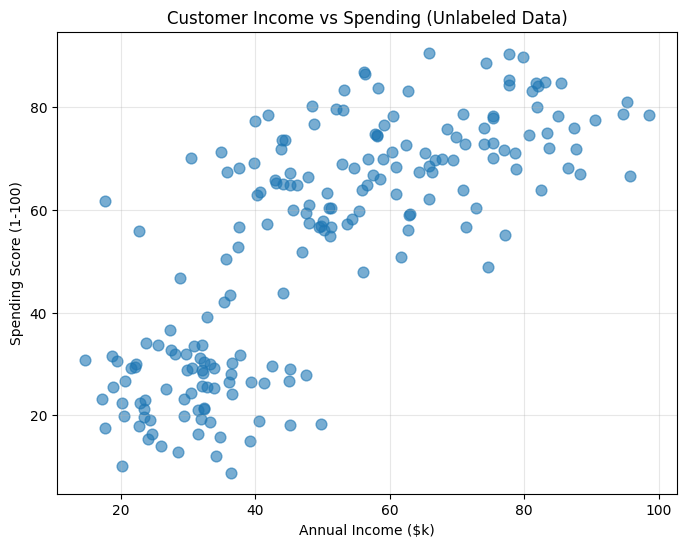

💡 Notice: We can visually see some natural groupings, but K-Means will find them algorithmically.


In [3]:
# Visualize the customer data
plt.figure(figsize=(8, 6))
plt.scatter(customers['Income'], customers['Spending_Score'], alpha=0.6, s=60)
plt.xlabel('Annual Income ($k)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Income vs Spending (Unlabeled Data)')
plt.grid(True, alpha=0.3)
plt.show()

print("💡 Notice: We can visually see some natural groupings, but K-Means will find them algorithmically.")

### Step 1: Standardize the Data

K-Means is sensitive to scale. We need to standardize features so they contribute equally to distance calculations.

In [4]:
# Standardize the features
scaler = StandardScaler()
customers_scaled = scaler.fit_transform(customers)

print(f"Original data shape: {customers.shape}")
print(f"Scaled data shape: {customers_scaled.shape}")
print(f"\nScaled data mean: {customers_scaled.mean():.6f} (should be ~0)")
print(f"Scaled data std: {customers_scaled.std():.6f} (should be ~1)")

Original data shape: (200, 2)
Scaled data shape: (200, 2)

Scaled data mean: 0.000000 (should be ~0)
Scaled data std: 1.000000 (should be ~1)


### Step 2: Fit K-Means with k=3

Let's assume we want to segment customers into 3 groups based on business requirements.

In [5]:
# Fit K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans.fit_predict(customers_scaled)

# Add cluster labels to original dataframe
customers['Cluster'] = cluster_labels

print(f"K-Means fitted with {kmeans.n_clusters} clusters")
print(f"\nCluster sizes:")
print(customers['Cluster'].value_counts().sort_index())

K-Means fitted with 3 clusters

Cluster sizes:
Cluster
0    75
1    74
2    51
Name: count, dtype: int64


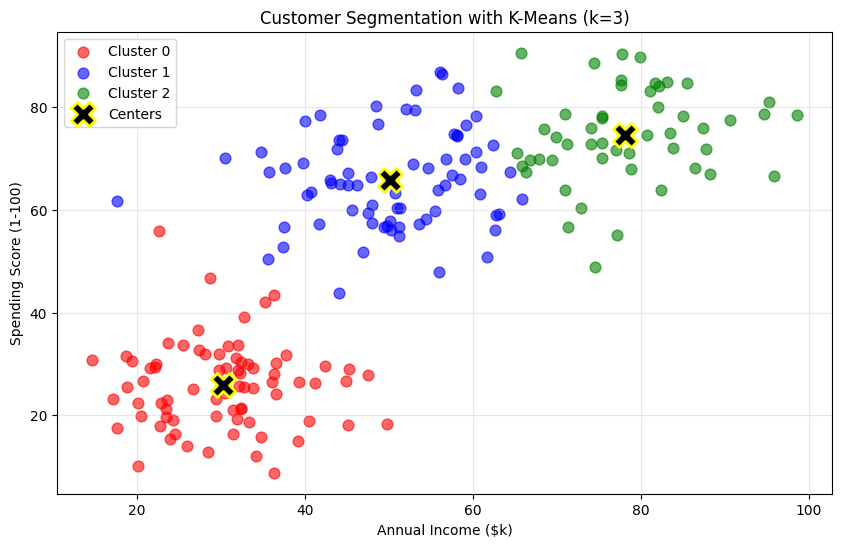

In [6]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green']
for cluster in range(3):
    cluster_data = customers[customers['Cluster'] == cluster]
    plt.scatter(cluster_data['Income'], cluster_data['Spending_Score'],
               c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6, s=60)

# Plot cluster centers (need to inverse transform)
centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centers_original[:, 0], centers_original[:, 1],
           c='black', marker='X', s=300, edgecolors='yellow', linewidths=2, label='Centers')

plt.xlabel('Annual Income ($k)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Segmentation with K-Means (k=3)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Step 3: Evaluate Clustering Quality

Two common metrics:
- **Inertia (WCSS)**: Sum of squared distances from points to their cluster centers (lower is better)
- **Silhouette Score**: Measures how similar points are to their own cluster vs. other clusters (-1 to 1, higher is better)

In [7]:
# Calculate clustering metrics
inertia = kmeans.inertia_
silhouette = silhouette_score(customers_scaled, cluster_labels)

print(f"Inertia (WCSS): {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.4f}")
print("\n💡 Interpretation:")
print(f"   - Silhouette score of {silhouette:.2f} suggests {'good' if silhouette > 0.5 else 'moderate'} cluster separation")
print("   - Scores closer to 1.0 indicate well-separated, compact clusters")

Inertia (WCSS): 62.90
Silhouette Score: 0.5420

💡 Interpretation:
   - Silhouette score of 0.54 suggests good cluster separation
   - Scores closer to 1.0 indicate well-separated, compact clusters


### Step 4: The Elbow Method

How do we choose k? The **elbow method** plots inertia for different k values and looks for an "elbow" where adding more clusters gives diminishing returns.

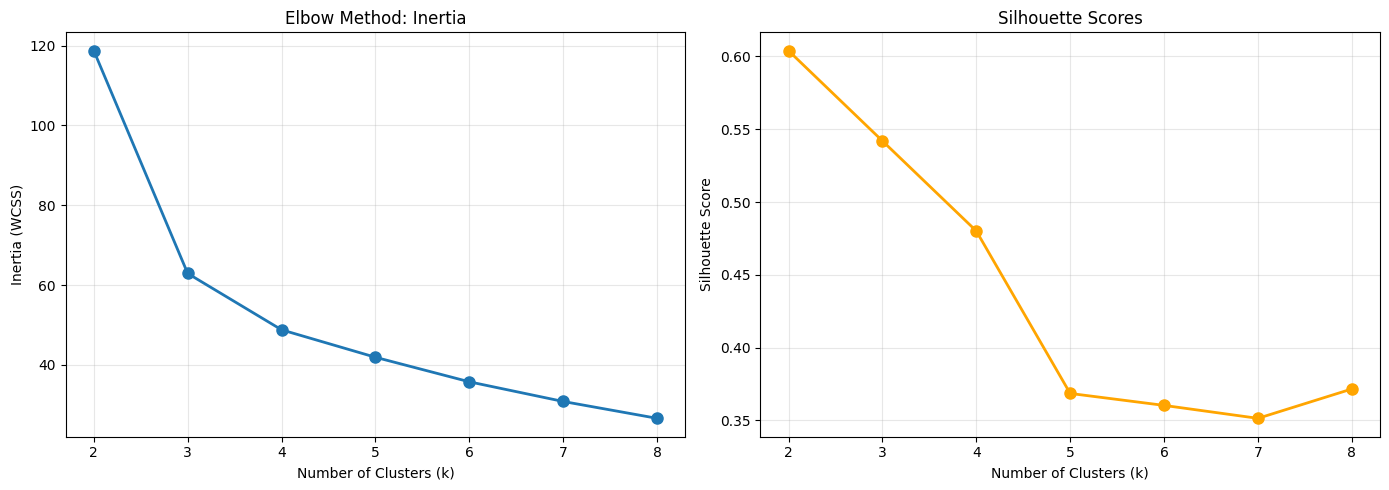

💡 Look for the 'elbow' where inertia starts decreasing more slowly.
   Best silhouette score: k=2


In [8]:
# Test different k values
k_range = range(2, 9)
inertias = []
silhouettes = []

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans_temp.fit(customers_scaled)
    inertias.append(kmeans_temp.inertia_)
    silhouettes.append(silhouette_score(customers_scaled, kmeans_temp.labels_))

# Plot elbow curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (WCSS)')
ax1.set_title('Elbow Method: Inertia')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range, silhouettes, marker='o', color='orange', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Scores')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Look for the 'elbow' where inertia starts decreasing more slowly.")
print(f"   Best silhouette score: k={list(k_range)[np.argmax(silhouettes)]}")

### 🧠 Your Turn — Interpret the Clusters

Now that you've clustered the customers, let's understand what makes each cluster unique.

**Tasks:**
- Calculate the mean income and spending score for each cluster
- Give each cluster a descriptive business name (e.g., "Budget Shoppers", "High Rollers")
- Consider: What marketing strategy would you recommend for each segment?

💡 **Hint:** Use `customers.groupby('Cluster')[['Income', 'Spending_Score']].mean()`

In [9]:
# Your code here

---

## Section 2: Introduction to Principal Component Analysis (PCA)

**PCA** reduces dimensionality by creating new features (principal components) that are combinations of original features. These components:
- Capture maximum variance in the data
- Are uncorrelated with each other
- Are ordered by importance (PC1 explains most variance, PC2 second-most, etc.)

### Example: Reducing Housing Features

Imagine you have many correlated housing features. PCA can reduce them to a few meaningful components.

In [10]:
# Create sample housing data with correlated features
np.random.seed(42)
n_houses = 100

# Base size variable
size_factor = np.random.normal(1500, 300, n_houses)

# Create correlated features based on size
housing_data = pd.DataFrame({
    'SqFt': size_factor + np.random.normal(0, 50, n_houses),
    'Bedrooms': (size_factor / 300) + np.random.normal(0, 0.5, n_houses),
    'Bathrooms': (size_factor / 400) + np.random.normal(0, 0.3, n_houses),
    'Garage_Cars': (size_factor / 600) + np.random.normal(0, 0.3, n_houses)
})

print(f"Housing data shape: {housing_data.shape}")
print(f"\nFirst few rows:")
print(housing_data.head())

print(f"\nCorrelation matrix (notice high correlations):")
print(housing_data.corr().round(2))

Housing data shape: (100, 4)

First few rows:
          SqFt  Bedrooms  Bathrooms  Garage_Cars
0  1578.245709  5.675608   3.873837     2.270029
1  1437.488444  5.142128   3.478247     2.251055
2  1677.170836  6.189214   4.459954     2.825417
3  1916.795093  7.049931   5.075383     3.275609
4  1421.689702  4.077012   3.568114     2.247904

Correlation matrix (notice high correlations):
             SqFt  Bedrooms  Bathrooms  Garage_Cars
SqFt         1.00      0.87       0.91         0.80
Bedrooms     0.87      1.00       0.82         0.68
Bathrooms    0.91      0.82       1.00         0.78
Garage_Cars  0.80      0.68       0.78         1.00


### Step 1: Standardize Before PCA

PCA is sensitive to scale, so we always standardize first (unless features are already on the same scale).

In [11]:
# Standardize the housing features
scaler_pca = StandardScaler()
housing_scaled = scaler_pca.fit_transform(housing_data)

print(f"Scaled data shape: {housing_scaled.shape}")
print(f"Mean: {housing_scaled.mean():.6f} (should be ~0)")
print(f"Std: {housing_scaled.std():.6f} (should be ~1)")

Scaled data shape: (100, 4)
Mean: 0.000000 (should be ~0)
Std: 1.000000 (should be ~1)


### Step 2: Fit PCA

Let's fit PCA with all components to see the full picture.

In [12]:
# Fit PCA with all components
pca_housing = PCA()
pca_housing.fit(housing_scaled)

print(f"Number of components: {pca_housing.n_components_}")
print(f"\nVariance explained by each component:")
for i, var in enumerate(pca_housing.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var*100:.2f}%")

print(f"\nCumulative variance:")
cumsum = np.cumsum(pca_housing.explained_variance_ratio_)
for i, var in enumerate(cumsum, 1):
    print(f"  First {i} PC(s): {var*100:.2f}%")

Number of components: 4

Variance explained by each component:
  PC1: 85.84%
  PC2: 8.27%
  PC3: 3.87%
  PC4: 2.02%

Cumulative variance:
  First 1 PC(s): 85.84%
  First 2 PC(s): 94.11%
  First 3 PC(s): 97.98%
  First 4 PC(s): 100.00%


### Step 3: Interpret Components with Loadings

**Loadings** show how original features contribute to each principal component. High absolute loadings indicate strong influence.

In [13]:
# Create loadings dataframe
loadings_df = pd.DataFrame(
    pca_housing.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_housing.n_components_)],
    index=housing_data.columns
)

print("Component Loadings:")
print(loadings_df.round(3))

print("\n💡 Interpretation:")
print("   PC1: All loadings are similar and positive → 'Overall house size'")
print("   PC2: Mixed signs → Captures contrasts between features")

Component Loadings:
               PC1    PC2    PC3    PC4
SqFt         0.522 -0.117  0.164  0.829
Bedrooms     0.492 -0.572 -0.598 -0.272
Bathrooms    0.512 -0.077  0.711 -0.475
Garage_Cars  0.472  0.809 -0.331 -0.117

💡 Interpretation:
   PC1: All loadings are similar and positive → 'Overall house size'
   PC2: Mixed signs → Captures contrasts between features


### Step 4: Visualize with Scree Plot

A **scree plot** helps decide how many components to keep.

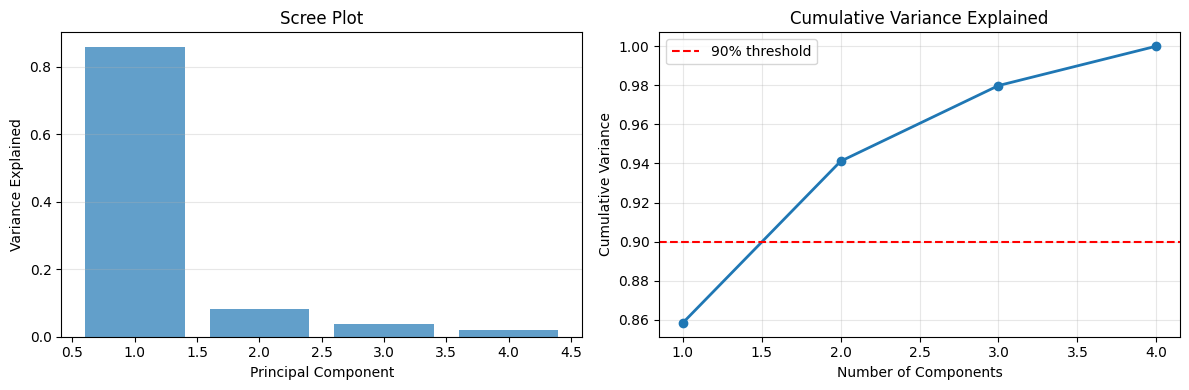

💡 PC1 alone captures 85.8% of variance!
   This makes sense: these features are highly correlated (all related to size).


In [14]:
# Create scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Individual variance
ax1.bar(range(1, len(pca_housing.explained_variance_ratio_) + 1),
        pca_housing.explained_variance_ratio_, alpha=0.7)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained')
ax1.set_title('Scree Plot')
ax1.grid(True, alpha=0.3, axis='y')

# Cumulative variance
cumulative = np.cumsum(pca_housing.explained_variance_ratio_)
ax2.plot(range(1, len(cumulative) + 1), cumulative, marker='o', linewidth=2)
ax2.axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance')
ax2.set_title('Cumulative Variance Explained')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"💡 PC1 alone captures {pca_housing.explained_variance_ratio_[0]*100:.1f}% of variance!")
print(f"   This makes sense: these features are highly correlated (all related to size).")

### Step 5: Transform the Data

Finally, we transform our data into the principal component space.

In [15]:
# Keep just 2 components for demonstration
pca_2 = PCA(n_components=2)
housing_pca = pca_2.fit_transform(housing_scaled)

print(f"Original shape: {housing_scaled.shape} (100 houses × 4 features)")
print(f"Transformed shape: {housing_pca.shape} (100 houses × 2 components)")
print(f"\nVariance retained: {pca_2.explained_variance_ratio_.sum()*100:.1f}%")

# Create dataframe with PC scores
housing_pca_df = pd.DataFrame(housing_pca, columns=['PC1', 'PC2'])
print("\nFirst few rows in PC space:")
print(housing_pca_df.head())

Original shape: (100, 4) (100 houses × 4 features)
Transformed shape: (100, 2) (100 houses × 2 components)

Variance retained: 94.1%

First few rows in PC space:
        PC1       PC2
0  0.512796 -0.694570
1 -0.304991 -0.350285
2  1.874676 -0.190936
3  3.585594 -0.091405
4 -0.731869  0.176772


---

# Part B: Homework Challenges (~35-40 min)

**IMPORTANT:** This section IS your homework for the week. You will complete these challenges and then answer questions in an online Canvas quiz based on your results.

For reproducibility and to ensure your quiz answers match your analysis, you **MUST** use the exact parameters specified below (random_state, n_init, test_size, etc.).

**DO NOT USE AI** to generate code for you. Write the code independently, building on what you learned in Part A. Feel free to ask the instructor for clarification or help if you get stuck.

## Challenge 1: K-Means Clustering on Housing Data

**Business Context:** You're a real estate analyst segmenting the Ames housing market to identify property types for targeted marketing. Your marketing team has requested 3 distinct segments.

**Your Task:** Apply K-Means clustering (k=3) to the Ames housing dataset and analyze cluster quality.

**Quiz Questions 1-4 will ask about your k=3 results. Record these values:**
- Final silhouette score (round to 4 decimals)
- Which cluster has the most homes?
- Final inertia/WCSS value (round to 2 decimals)
- Best k value by silhouette score from elbow analysis

### Instructions:

**Step 1:** Load the Ames housing data

In [16]:
# Load Ames housing data
ames = pd.read_csv('https://raw.githubusercontent.com/bradleyboehmke/uc-bana-4080/main/data/ames_clean.csv')

print(f"Ames data shape: {ames.shape}")
ames.head()

Ames data shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Step 2:** Select exactly these features for clustering and handle missing values

In [17]:
# Your code here: Select these exact features
features = ['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearBuilt', 'OverallQual', 'OverallCond']

# Your code here: Handle missing values
# Fill TotalBsmtSF and GarageArea missing values with 0
# Create ames_cluster dataframe with selected features

cluster_data = ames[features].fillna(0)

print(f"Cluster data shape: {cluster_data.shape}")
cluster_data.head()



Cluster data shape: (1460, 6)


,GrLivArea,TotalBsmtSF,GarageArea,YearBuilt,OverallQual,OverallCond
0,1710,856,548,2003,7,5
1,1262,1262,460,1976,6,8
2,1786,920,608,2001,7,5
3,1717,756,642,1915,7,5
4,2198,1145,836,2000,8,5


**Step 3:** Standardize the features

In [19]:
# Your code here: Standardize using StandardScaler
scale = StandardScaler()
ames_scaled = scale.fit_transform(cluster_data)

**Step 4:** Perform elbow analysis (k from 2 to 10)

**CRITICAL:** Use `random_state=42` and `n_init=10` for all K-Means models

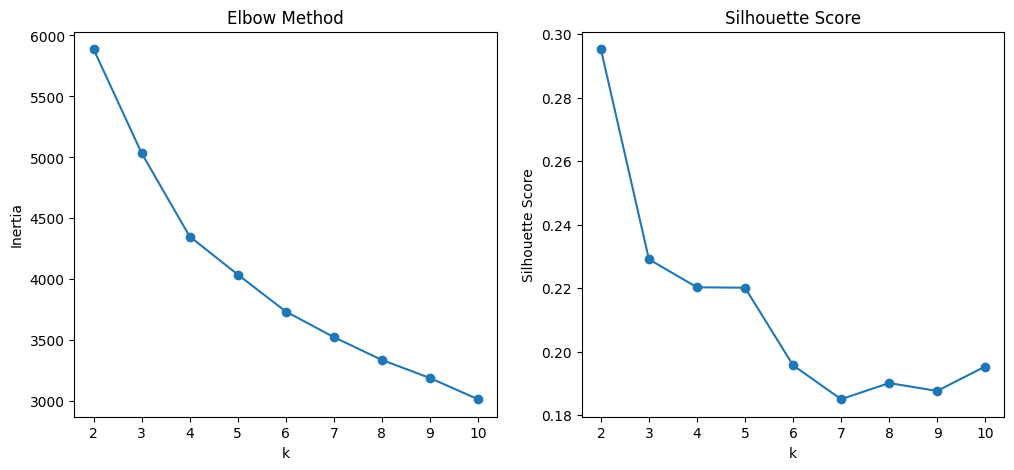

Best k by silhouette score: 2


In [20]:
# Your code here:
# - Loop through k values from 2 to 10
# - For each k, fit KMeans(n_clusters=k, random_state=42, n_init=10)
# - Store inertia and silhouette scores
# - Create elbow plots
# - Identify best k by silhouette score

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

k_values = range(2, 11)
wcss_list = []
sil_list = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = km.fit_predict(ames_scaled)
    wcss_list.append(km.inertia_)
    sil_list.append(silhouette_score(ames_scaled, cluster_labels))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, wcss_list, "-o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")

plt.subplot(1, 2, 2)
plt.plot(k_values, sil_list, "-o")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score")

plt.show()

best_k = k_values[np.argmax(sil_list)]
print("Best k by silhouette score:", best_k)


**📝 RECORD THIS FOR QUIZ (Question 4):**

Which k value had the highest silhouette score?

**Step 5:** Fit final K-Means model with k=3

**CRITICAL:** Use `random_state=42` and `n_init=10`

In [21]:
# Your code here:
# - Fit KMeans with k=3, random_state=42, n_init=10
# - Calculate final inertia
# - Calculate final silhouette score
# - Print cluster sizes
km_final = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = km_final.fit_predict(ames_scaled)

final_inertia = km_final.inertia_
final_silhouette = silhouette_score(ames_scaled, cluster_labels)

ames["Cluster"] = cluster_labels

print(f"Final inertia (WCSS): {final_inertia:.2f}")
print(f"Final silhouette score: {final_silhouette:.4f}")
print("Cluster sizes:\n", ames["Cluster"].value_counts())


Final inertia (WCSS): 5034.51
Final silhouette score: 0.2291
Cluster sizes:
 Cluster
0    594
1    505
2    361
Name: count, dtype: int64


**📝 RECORD THESE FOR QUIZ:**

- **Question 1:** Final silhouette score (round to 4 decimals)
- **Question 2:** Which cluster (0, 1, or 2) contains the most homes?
- **Question 3:** Final inertia/WCSS value (round to 2 decimals)

---

## Challenge 2: PCA on Breast Cancer Data

**Business Context:** You're a data scientist working with medical researchers who have 30 tumor measurements per patient. The dataset is high-dimensional and hard to visualize. You'll use PCA to reduce dimensionality while preserving diagnostic information.

**Your Task:** Apply PCA to the breast cancer dataset and analyze variance explained.

**Quiz Questions 5-9 will ask about your PCA results. Record:**
- PC1 variance % (round to 2 decimals)
- PC1+PC2 cumulative variance % (round to 2 decimals)
- Number of components for 90% variance
- Number of components for 95% variance
- Top 5 features for PC1 by absolute loading

### Instructions:

**Step 1:** Load the breast cancer data

In [22]:
breast_cancer = pd.read_csv('https://raw.githubusercontent.com/bradleyboehmke/uc-bana-4080/main/data/breast_cancer.csv')

# Separate features and target
X = breast_cancer.drop('diagnosis', axis=1)
y = breast_cancer['diagnosis']

print(f"Features: {X.shape[1]} features")
print(f"Samples: {X.shape[0]} patients")
print(f"Diagnoses: {(y=='M').sum()} Malignant, {(y=='B').sum()} Benign")


Features: 30 features
Samples: 569 patients
Diagnoses: 212 Malignant, 357 Benign


**Step 2:** Standardize the features

**CRITICAL:** Use `random_state=42` for all operations

In [23]:
# Your code here: Standardize using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Step 3:** Fit PCA with all components

In [24]:
# Your code here:
# - Fit PCA() with all components
# - Calculate explained variance ratio for each component
# - Calculate cumulative variance

pca_obj = PCA(random_state=42)
X_pca = pca_obj.fit_transform(X_scaled)

explained_var = pca_obj.explained_variance_ratio_
cum_explained = np.cumsum(explained_var)

print(f"PC1 variance: {explained_var[0] * 100:.2f}%")
print(f"PC1 + PC2 cumulative variance: {cum_explained[1] * 100:.2f}%")



PC1 variance: 44.27%
PC1 + PC2 cumulative variance: 63.24%


**📝 RECORD THESE FOR QUIZ:**

- **Question 5:** PC1 variance % (round to 2 decimals, e.g., 44.27)
- **Question 6:** PC1+PC2 cumulative variance % (round to 2 decimals)

**Step 4:** Determine components needed for 90% and 95% variance

In [25]:
# Your code here:
# - Find number of components for 90% variance threshold
# - Find number of components for 95% variance threshold
# Hint: Use np.argmax(cumulative_variance >= 0.90) + 1
n_90 = np.argmax(cum_explained >= 0.90) + 1
n_95 = np.argmax(cum_explained >= 0.95) + 1

print(f"Number of components for 90% variance: {n_90}")
print(f"Number of components for 95% variance: {n_95}")


Number of components for 90% variance: 7
Number of components for 95% variance: 10


**📝 RECORD THESE FOR QUIZ:**

- **Question 7:** How many components needed for 90% variance?
- **Question 8:** How many components needed for 95% variance?

**Step 5:** Analyze PC1 loadings

In [26]:
# Your code here:
# - Create loadings dataframe from pca.components_
# - Find top 5 features for PC1 by absolute loading value
# - Print feature names and their loadings

loadings = pd.DataFrame(
    pca_obj.components_.T,
    columns=[f"PC{i+1}" for i in range(pca_obj.n_components_)],
    index=X.columns
)

pc1_vals = loadings["PC1"].abs().sort_values(ascending=False)
print(pc1_vals.head(5))


concave points_mean     0.260854
concavity_mean          0.258400
concave points_worst    0.250886
compactness_mean        0.239285
perimeter_worst         0.236640
Name: PC1, dtype: float64


**📝 RECORD THIS FOR QUIZ:**

- **Question 9:** What are the top 5 features (by absolute loading) for PC1?

**Step 6:** Create visualizations (scree plot)

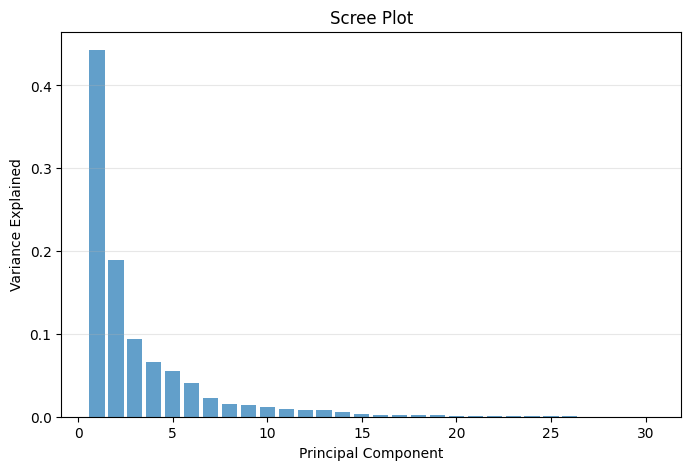

In [27]:
# Your code here: Create scree plot showing variance explained
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.7)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Scree Plot")
plt.grid(axis="y", alpha=0.3)
plt.show()

---

## Challenge 3: PCA + Logistic Regression

**Business Context:** You're building a breast cancer diagnostic system. Your stakeholders want high accuracy but also model efficiency (fast predictions, easy deployment). You'll compare a baseline model using all 30 features against PCA-reduced models.

**Your Task:** Compare logistic regression performance with and without PCA.

**Quiz Questions 10-15 will ask about model performance. Record:**
- Baseline test accuracy (all 30 features)
- PCA model test accuracy (10 components, 95% variance)
- Best configuration test accuracy
- Overfitting gaps for baseline and PCA models
- Dimensionality reduction percentage

### Instructions:

**Step 1:** Train-test split

**CRITICAL:** Use `test_size=0.2`, `random_state=42`, `stratify=y`

In [28]:
# Your code here:
# - Split X and y with test_size=0.2, random_state=42, stratify=y
# - Standardize training and test data separately

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler_obj = StandardScaler()
X_train_scaled = scaler_obj.fit_transform(X_train)
X_test_scaled = scaler_obj.transform(X_test)


**Step 2:** Baseline model (all 30 features)

**CRITICAL:** Use `LogisticRegression(max_iter=10000, random_state=42)`

In [29]:
# Your code here:
# - Train logistic regression on standardized training data
# - Calculate training accuracy
# - Calculate test accuracy
# - Calculate overfitting gap (train_acc - test_acc)

log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

train_score = log_reg.score(X_train_scaled, y_train)
test_score = log_reg.score(X_test_scaled, y_test)
gap_score = train_score - test_score

print(f"Baseline train accuracy: {train_score:.4f}")
print(f"Baseline test accuracy: {test_score:.4f}")
print(f"Baseline overfitting gap: {gap_score:.4f}")


Baseline train accuracy: 0.9868
Baseline test accuracy: 0.9649
Baseline overfitting gap: 0.0219


**📝 RECORD THESE FOR QUIZ:**

- **Question 10:** Baseline test accuracy (round to 4 decimals)
- **Question 13:** Baseline overfitting gap (round to 4 decimals)

**Step 3:** PCA model with 95% variance

**CRITICAL:** Use `PCA(n_components=0.95, random_state=42)` and `LogisticRegression(max_iter=10000, random_state=42)`

In [30]:
# Your code here:
# - Apply PCA(n_components=0.95) to training data (fit_transform)
# - Transform test data using the same PCA
# - Train logistic regression on PCA-transformed training data
# - Calculate training and test accuracies
# - Calculate overfitting gap
# - Calculate dimensionality reduction percentage: (1 - n_components/30) * 100

pca_red = PCA(n_components=0.95, random_state=42)
X_train_pca = pca_red.fit_transform(X_train_scaled)
X_test_pca = pca_red.transform(X_test_scaled)

log_reg_pca = LogisticRegression(max_iter=10000, random_state=42)
log_reg_pca.fit(X_train_pca, y_train)

train_acc_pca = log_reg_pca.score(X_train_pca, y_train)
test_acc_pca = log_reg_pca.score(X_test_pca, y_test)
overfit_gap_pca = train_acc_pca - test_acc_pca

orig_dim = X_train_scaled.shape[1]
dim_red_pct = (1 - X_train_pca.shape[1] / orig_dim) * 100

print(f"PCA test accuracy: {test_acc_pca:.4f}")
print(f"PCA overfitting gap: {overfit_gap_pca:.4f}")
print(f"Dimensionality reduction (%): {dim_red_pct:.1f}%")


PCA test accuracy: 0.9737
PCA overfitting gap: 0.0131
Dimensionality reduction (%): 66.7%


**📝 RECORD THESE FOR QUIZ:**

- **Question 11:** PCA model test accuracy (round to 4 decimals)
- **Question 14:** PCA model overfitting gap (round to 4 decimals)
- **Question 15:** Dimensionality reduction percentage (should be 66.7%)

**Step 4:** Compare multiple PCA configurations

Test with 2, 5, 10, 15, 20, 25 components to find the best configuration.

**CRITICAL:** Use `random_state=42` for all PCA and LogisticRegression models

In [31]:
# Your code here:
# - Loop through n_components_list = [2, 5, 10, 15, 20, 25]
# - For each, fit PCA, transform data, train logistic regression
# - Record training and test accuracies
# - Find configuration with best test accuracy

accuracies = []
n_components_list = [2, 5, 10, 15, 20, 25]

for n_comp in n_components_list:
    pca_model = PCA(n_components=n_comp, random_state=42)
    X_train_pca = pca_model.fit_transform(X_train_scaled)
    X_test_pca = pca_model.transform(X_test_scaled)

    log_reg = LogisticRegression(max_iter=10000, random_state=42)
    log_reg.fit(X_train_pca, y_train)

    test_acc = log_reg.score(X_test_pca, y_test)
    accuracies.append(test_acc)


**📝 RECORD THIS FOR QUIZ:**

- **Question 12:** Which configuration (number of components) achieved the highest test accuracy?

**Step 5:** Create comparison summary and visualization

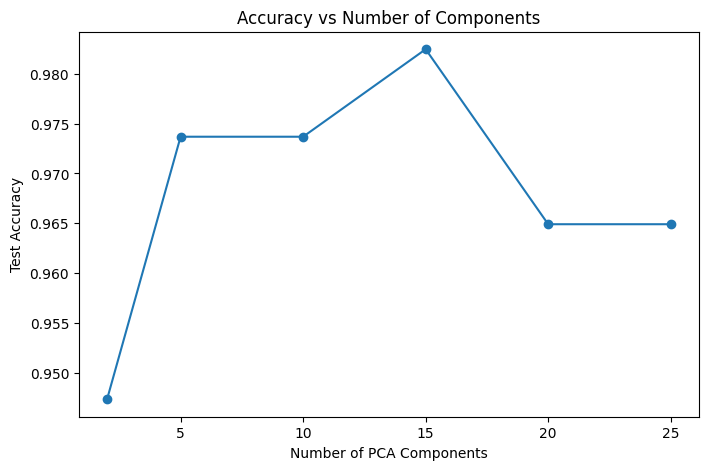

Best configuration: 15 components, test accuracy: 0.9825


In [32]:
# Your code here:
# - Create summary table comparing baseline vs PCA models
# - Create plot showing accuracy vs number of components

plt.figure(figsize=(8, 5))
plt.plot(n_components_list, accuracies, "-o")
plt.xlabel("Number of PCA Components")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs Number of Components")
plt.show()

best_idx = np.argmax(accuracies)
best_n = n_components_list[best_idx]
best_acc = accuracies[best_idx]

print(f"Best configuration: {best_n} components, test accuracy: {best_acc:.4f}")

---

## 🎯 Lab Wrap-Up & Reflection

### ✅ What You Accomplished
In this lab, you practiced:
- Applying K-Means clustering to segment data into meaningful groups
- Using the elbow method and silhouette scores to evaluate cluster quality
- Interpreting cluster characteristics for business insights
- Executing the complete PCA workflow from standardization to transformation
- Using scree plots to determine optimal components
- Interpreting component loadings to understand what PCs represent
- Comparing ML models with original vs. PCA-transformed features
- Evaluating tradeoffs between dimensionality reduction and performance

### 🤔 Reflection Questions
Take 2-3 minutes to consider:
- When would you choose clustering over PCA, and vice versa?
- What surprised you about the PCA results? Did reducing dimensions improve or hurt model performance?
- How might you use these techniques in a real data science project?

### 🔗 Connection to Course Goals
Unsupervised learning completes your machine learning toolkit. You now know supervised learning (prediction with labels), unsupervised learning (pattern discovery without labels), and how to combine these techniques effectively. These are foundational skills for any data science role.

### 📋 Next Steps
- **Quiz:** Complete the Week 13 online quiz in Canvas using your recorded answers from Part B
- **Next Week:** Final exam review and course wrap-up
- **Additional Practice:** Try PCA on other high-dimensional datasets (images, text, genomics)

---
**💾 Save your work** and make sure you've recorded all the values needed for the quiz!

## 🚨 Troubleshooting & Common Issues

**Issue 1:** "My silhouette scores don't match the quiz"
- **Solution:** Make sure you're using exactly `random_state=42` and `n_init=10` for all KMeans models. Also verify you filled missing values correctly (TotalBsmtSF and GarageArea with 0).

**Issue 2:** "My PCA variance percentages are slightly different"
- **Solution:** Ensure you standardized the data before PCA. Also round to the exact number of decimals specified (2 decimals for variance %, 4 decimals for accuracy).

**Issue 3:** "My logistic regression accuracies don't match"
- **Solution:** Check three things: (1) `test_size=0.2, random_state=42, stratify=y` in train_test_split, (2) `max_iter=10000, random_state=42` in LogisticRegression, (3) `random_state=42` in PCA.

**Issue 4:** "What if my silhouette score for k=3 is slightly off?"
- **Solution:** The quiz accepts a small range (e.g., 0.2280-0.2300). If you're outside this range, double-check your random_state and n_init parameters.

**General Debugging Tips:**
- Print intermediate results to verify each step
- Check data shapes after each transformation
- Make sure you're fitting on training data and transforming both train and test
- If stuck, review the guided examples in Part A for similar patterns